# Step 1: Patch Generator Code

In [1]:
# import os
# import random
# import numpy as np
# from tensorflow.keras.utils import Sequence
# from PIL import Image

# class DIV2KGenerator(Sequence):
#     def __init__(self, hr_dir, lr_dir, scale=4, patch_size=96, batch_size=16):
#         self.hr_dir = hr_dir
#         self.lr_dir = lr_dir
#         self.scale = scale
#         self.hr_patch_size = patch_size
#         self.lr_patch_size = patch_size // scale
#         self.batch_size = batch_size
#         self.image_filenames = sorted(os.listdir(hr_dir))
        
#     def __len__(self):
#         return len(self.image_filenames) // self.batch_size

#     def __getitem__(self, idx):
#         batch_hr = []
#         batch_lr = []
#         batch_filenames = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        
#         for fname in batch_filenames:
#             hr_path = os.path.join(self.hr_dir, fname)
#             lr_path = os.path.join(self.lr_dir, fname)

#             hr_img = Image.open(hr_path).convert("RGB")
#             lr_img = Image.open(lr_path).convert("RGB")

#             hr_img = np.array(hr_img)
#             lr_img = np.array(lr_img)

#             # Random crop from LR image
#             h, w, _ = lr_img.shape
#             x = random.randint(0, w - self.lr_patch_size)
#             y = random.randint(0, h - self.lr_patch_size)

#             lr_crop = lr_img[y:y + self.lr_patch_size, x:x + self.lr_patch_size]
#             hr_crop = hr_img[y*self.scale:y*self.scale + self.hr_patch_size,
#                              x*self.scale:x*self.scale + self.hr_patch_size]

#             # Normalize to [-1, 1]
#             lr_crop = lr_crop / 127.5 - 1.0
#             hr_crop = hr_crop / 127.5 - 1.0

#             batch_lr.append(lr_crop)
#             batch_hr.append(hr_crop)

#         return np.array(batch_lr), np.array(batch_hr)


2025-05-28 17:59:21.211364: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 17:59:21.391647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748455161.494115     485 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748455161.522229     485 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748455161.775558     485 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Step 2: Data Loader for DIV2K HR / LR Pairs

In [2]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random

class DIV2KSequence(Sequence):
    def __init__(self, hr_dir, lr_dir, batch_size=16, patch_size=64, scale=4):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.batch_size = batch_size
        self.patch_size = patch_size  # LR patch size
        self.scale = scale  # X4
        self.hr_patch_size = patch_size * scale
        
        self.image_names = sorted(os.listdir(lr_dir))  # All images are paired by name

    def __len__(self):
        return len(self.image_names) // self.batch_size

    def __getitem__(self, idx):
        batch_hr = []
        batch_lr = []

        batch_files = self.image_names[idx * self.batch_size:(idx + 1) * self.batch_size]
        for fname in batch_files:
            hr_fname = fname[:4] + ".png"
            hr_path = os.path.join(self.hr_dir, hr_fname)
            lr_path = os.path.join(self.lr_dir, fname)

            hr_img = img_to_array(load_img(hr_path))  # shape: (H, W, 3)
            lr_img = img_to_array(load_img(lr_path))  # shape: (H/4, W/4, 3)

            # Extract matching patches from LR and HR
            h, w, _ = lr_img.shape
            if h < self.patch_size or w < self.patch_size:
                continue  # skip small images

            # Random top-left corner
            x = random.randint(0, w - self.patch_size)
            y = random.randint(0, h - self.patch_size)

            # LR patch
            lr_patch = lr_img[y:y+self.patch_size, x:x+self.patch_size, :]

            # HR patch at the corresponding location
            hr_x = x * self.scale
            hr_y = y * self.scale
            hr_patch = hr_img[hr_y:hr_y+self.hr_patch_size, hr_x:hr_x+self.hr_patch_size, :]

            # Normalize to [-1, 1]
            lr_patch = (lr_patch / 127.5) - 1.0
            hr_patch = (hr_patch / 127.5) - 1.0

            batch_lr.append(lr_patch)
            batch_hr.append(hr_patch)

        return np.array(batch_lr), np.array(batch_hr)


# Step 3: Test the DIV2KSequence Generator

In [3]:
import matplotlib.pyplot as plt

# Change to your actual paths
hr_dir = "./datasets/DIV2K/DIV2K_train_HR"
lr_dir = "./datasets/DIV2K/DIV2K_train_LR_bicubic/X4"

# Instantiate generator
gen = DIV2KSequence(hr_dir=hr_dir, lr_dir=lr_dir, batch_size=4, patch_size=64, scale=4)

# Load one batch
lr_batch, hr_batch = gen[0]

print("LR batch shape:", lr_batch.shape)  # Expected: (4, 64, 64, 3)
print("HR batch shape:", hr_batch.shape)  # Expected: (4, 256, 256, 3)

print("LR pixel value range: [{:.2f}, {:.2f}]".format(lr_batch.min(), lr_batch.max()))
print("HR pixel value range: [{:.2f}, {:.2f}]".format(hr_batch.min(), hr_batch.max()))


LR batch shape: (4, 64, 64, 3)
HR batch shape: (4, 256, 256, 3)
LR pixel value range: [-1.00, 0.92]
HR pixel value range: [-1.00, 1.00]


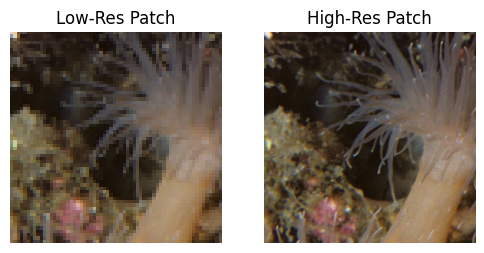

In [4]:
# Denormalize for display
def denormalize(img):
    return ((img + 1.0) * 127.5).astype("uint8")

# Show first image in batch
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Low-Res Patch")
plt.imshow(denormalize(lr_batch[i]))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("High-Res Patch")
plt.imshow(denormalize(hr_batch[i]))
plt.axis("off")
plt.show()

# Step 4: Build the Generator in Keras

In [22]:
# from tensorflow.keras.layers import Input, Conv2D, PReLU, Add, UpSampling2D, Lambda
# from tensorflow.keras.models import Model
# import tensorflow as tf

# def residual_block(x_in, filters=64):
#     x = Conv2D(filters, kernel_size=3, padding='same')(x_in)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = PReLU(shared_axes=[1,2])(x)
#     x = Conv2D(filters, kernel_size=3, padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     return Add()([x_in, x])  # Skip connection

# def build_generator(scale=4):
#     input_lr = Input(shape=(None, None, 3))  # Accept any input resolution

#     # Initial feature extraction
#     x_start = Conv2D(64, kernel_size=9, padding='same')(input_lr)
#     x_start = PReLU(shared_axes=[1,2])(x_start)

#     # Residual blocks (fewer for Lite version)
#     x = x_start
#     for _ in range(8):  # Original SRGAN used 16, we use 8
#         x = residual_block(x, filters=64)

#     # Reconstruction
#     x = Conv2D(64, kernel_size=3, padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = Add()([x, x_start])

#     # Upsampling x2 twice = x4
#     for _ in range(int(tf.math.log(float(scale)) / tf.math.log(2.0))):
#         x = UpSampling2D(size=2)(x)
#         x = Conv2D(64, kernel_size=3, padding='same')(x)
#         x = PReLU(shared_axes=[1,2])(x)

#     output_hr = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)

#     return Model(inputs=input_lr, outputs=output_hr, name="SRGAN_Lite_Generator")

In [21]:
from tensorflow.keras.layers import Conv2D, LeakyReLU, Add, Input, UpSampling2D, PReLU
from tensorflow.keras.models import Model

def residual_block(input_tensor, filters):
    x = Conv2D(filters, kernel_size=3, padding='same')(input_tensor)
    x = PReLU(shared_axes=[1, 2])(x)
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    return Add()([input_tensor, x])

def build_generator_lite(input_shape=(64, 64, 3), num_res_blocks=4):
    inputs = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(64, kernel_size=9, padding='same')(inputs)
    x = PReLU(shared_axes=[1, 2])(x)
    residual = x

    # Lightweight Residual Blocks
    for _ in range(num_res_blocks):
        residual = residual_block(residual, 64)

    # Convolution after residual blocks
    x = Conv2D(64, kernel_size=3, padding='same')(residual)
    x = Add()([x, residual])

    # Upsampling blocks
    for _ in range(2):  # 2x2 = 4x scale
        x = UpSampling2D()(x)
        x = Conv2D(64, kernel_size=3, padding='same')(x)
        x = PReLU(shared_axes=[1, 2])(x)

    # Final output layer
    outputs = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)

    return Model(inputs, outputs)

# Step 5: Visualize Generator Output from a Real DIV2K LR Image

I0000 00:00:1748455169.833634     485 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1748455171.332599     633 service.cc:152] XLA service 0x72749c013f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748455171.332639     633 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-05-28 17:59:31.361916: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748455171.566170     633 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-28 17:59:35.934551: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bias-activation.82 = (f32[1,64,1332,2040]{

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


I0000 00:00:1748455182.429187     633 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


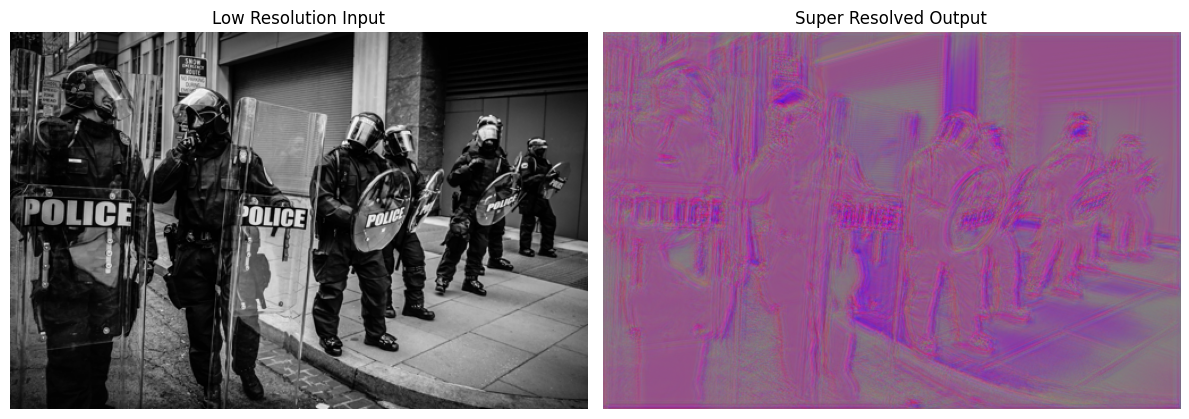

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Load the generator model
generator = build_generator(scale=4)
# If you have pretrained weights, you can load them here:
# generator.load_weights("generator_weights.h5")

# Pick a sample image path
sample_lr_path = os.path.join("./datasets/DIV2K/DIV2K_train_LR_bicubic/X4", "0800x4.png")

# Load and preprocess the LR image
lr_img = Image.open(sample_lr_path).convert("RGB")
lr_array = np.array(lr_img).astype(np.float32)
lr_norm = (lr_array / 127.5) - 1.0  # Normalize to [-1, 1]
lr_input = np.expand_dims(lr_norm, axis=0)  # Add batch dimension

# Generate super-resolved image
sr_output = generator.predict(lr_input)[0]  # Remove batch dim

# Denormalize to [0, 255]
sr_image = ((sr_output + 1) * 127.5).clip(0, 255).astype(np.uint8)

# Show side-by-side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(lr_array.astype(np.uint8))
plt.title("Low Resolution Input")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sr_image)
plt.title("Super Resolved Output")
plt.axis("off")
plt.tight_layout()
plt.show()

# Step 6: Build the Discriminator

In [7]:
# from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Input
# from tensorflow.keras.models import Model

# def build_discriminator(input_shape=(None, None, 3)):
#     def disc_block(x, filters, strides):
#         x = Conv2D(filters, kernel_size=3, strides=strides, padding="same")(x)
#         x = BatchNormalization()(x)
#         x = LeakyReLU(0.2)(x)
#         return x

#     inp = Input(shape=input_shape)
#     x = Conv2D(64, kernel_size=3, strides=1, padding="same")(inp)
#     x = LeakyReLU(0.2)(x)

#     x = disc_block(x, 64, 2)
#     x = disc_block(x, 128, 1)
#     x = disc_block(x, 128, 2)
#     x = disc_block(x, 256, 1)
#     x = disc_block(x, 256, 2)
#     x = disc_block(x, 512, 1)
#     x = disc_block(x, 512, 2)

#     # Final classification layer (PatchGAN style)
#     x = Conv2D(1, kernel_size=3, strides=1, padding="same", activation="sigmoid")(x)

#     model = Model(inp, x, name="discriminator")
#     return model

In [20]:
from tensorflow.keras.layers import BatchNormalization, Flatten, Dense
from tensorflow.keras.layers import MaxPooling2D

def build_discriminator_lite(input_shape=(256, 256, 3)):
    def conv_block(x, filters, strides=1):
        x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        return x

    inp = Input(shape=input_shape)
    x = conv_block(inp, 64)
    x = conv_block(x, 64, strides=2)

    x = conv_block(x, 128)
    x = conv_block(x, 128, strides=2)

    x = conv_block(x, 256)
    x = conv_block(x, 256, strides=2)

    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)

    return Model(inp, out)

### Test the Discriminator

In [8]:
# Build it
discriminator = build_discriminator()

# Try a dummy input
dummy_hr = tf.random.normal((1, 96, 96, 3))  # HR image size patch
decision = discriminator(dummy_hr)

print("Discriminator output shape:", decision.shape)

Discriminator output shape: (1, 6, 6, 1)


# Discriminator Training Code: Inside Training Loop 

In [9]:
# import os
# import tensorflow as tf

# # Example: replace with actual paths
# hr_dir = './datasets/DIV2K/DIV2K_train_HR'
# lr_dir = './datasets/DIV2K/DIV2K_train_LR_bicubic/X4'

# hr_image_paths = sorted([os.path.join(hr_dir, x) for x in os.listdir(hr_dir)])
# lr_image_paths = sorted([os.path.join(lr_dir, x) for x in os.listdir(lr_dir)])

In [10]:
# def load_and_preprocess_images(lr_path, hr_path):
#     lr_img = tf.io.read_file(lr_path)
#     lr_img = tf.image.decode_png(lr_img, channels=3)
#     lr_img = tf.image.convert_image_dtype(lr_img, tf.float32)  # normalized [0, 1]

#     hr_img = tf.io.read_file(hr_path)
#     hr_img = tf.image.decode_png(hr_img, channels=3)
#     hr_img = tf.image.convert_image_dtype(hr_img, tf.float32)

#     return lr_img, hr_img

In [11]:
# AUTOTUNE = tf.data.AUTOTUNE

# # Create a tf.data.Dataset of file paths
# path_ds = tf.data.Dataset.from_tensor_slices((lr_image_paths, hr_image_paths))

# # Map and batch
# train_dataset = (
#     path_ds
#     .map(load_and_preprocess_images, num_parallel_calls=AUTOTUNE)
#     .batch(16)  # Choose your batch size here
#     .prefetch(AUTOTUNE)
# )

In [40]:
# import numpy as np

# # === Inside your training loop for each batch ===
# for step, (lr_imgs, hr_imgs) in enumerate(train_dataset):

#     # ---------------------------------------------------
#     # 1. Generate super-resolved (fake) images from LR input
#     # ---------------------------------------------------
#     fake_hr_imgs = generator.predict(lr_imgs)

#     # ---------------------------------------------------
#     # 2. Create labels for real and fake images
#     # ---------------------------------------------------
#     real_labels = np.ones((lr_imgs.shape[0], 1))  # shape: (batch_size, 1)
#     fake_labels = np.zeros((lr_imgs.shape[0], 1)) # shape: (batch_size, 1)

#     # ---------------------------------------------------
#     # 3. Train discriminator on real HR images
#     # ---------------------------------------------------
#     d_loss_real = discriminator.train_on_batch(hr_imgs, real_labels)

#     # ---------------------------------------------------
#     # 4. Train discriminator on fake HR images from generator
#     # ---------------------------------------------------
#     d_loss_fake = discriminator.train_on_batch(fake_hr_imgs, fake_labels)

#     # ---------------------------------------------------
#     # 5. Average the two losses to get total discriminator loss
#     # ---------------------------------------------------
#     d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

#     # Optional: Print or log discriminator loss
#     print(f"Step {step+1} - D Loss: {d_loss}")


In [12]:
@tf.function
def train_discriminator_step(lr_imgs, hr_imgs):
    # Generate super-resolved images
    sr_imgs = generator(lr_imgs, training=True)

    with tf.GradientTape() as tape:
        # Discriminator predictions
        real_output = discriminator(hr_imgs, training=True)
        fake_output = discriminator(sr_imgs, training=True)

        # Labels: 1 for real, 0 for fake
        real_labels = tf.ones_like(real_output)
        fake_labels = tf.zeros_like(fake_output)

        # Compute loss
        d_loss_real = bce(real_labels, real_output)
        d_loss_fake = bce(fake_labels, fake_output)
        d_loss = d_loss_real + d_loss_fake

    # Backpropagate and update discriminator weights
    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return d_loss

# Generator training step

In [13]:
@tf.function
def train_generator_step(lr_imgs, hr_imgs):
    with tf.GradientTape() as tape:
        # Generate SR images
        sr_imgs = generator(lr_imgs, training=True)

        # Discriminator output (used in adversarial loss)
        fake_output = discriminator(sr_imgs, training=True)
        adversarial_loss = bce(tf.ones_like(fake_output), fake_output)

        # Extract VGG features
        sr_features = vgg(sr_imgs)
        hr_features = vgg(hr_imgs)

        # Perceptual loss
        perceptual_loss = mse(hr_features, sr_features)

        # Total generator loss
        gen_loss = perceptual_loss + 1e-3 * adversarial_loss

    # Update generator
    grads = tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return gen_loss


# VGG model

In [25]:
# from tensorflow.keras.applications import VGG19
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications.vgg19 import preprocess_input

# def build_vgg():
#     # Input shape must be 3D (H, W, 3), images scaled to [0, 255]
#     vgg = VGG19(weights='imagenet', include_top=False)
    
#     # We'll extract features from block5_conv4 as in SRGAN paper
#     model = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)

#     # Freeze the model so it's not trained
#     model.trainable = False
#     return model

# def preprocess_vgg(imgs):
#     # From [0, 1] to [0, 255]
#     imgs = imgs * 255.0
#     return preprocess_input(imgs)

In [28]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input

def vgg_loss_model(hr_shape=(256, 256, 3)):
    """
    Returns a VGG19 model that outputs feature maps from the 'block5_conv4' layer.
    Used to compute perceptual loss.
    """
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=hr_shape)
    vgg.trainable = False  # freeze all VGG layers

    # We'll use 'block5_conv4' output for perceptual loss (you can try 'block3_conv3' for a lighter version)
    model = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
    return model

def preprocess_vgg(x):
    """
    Rescale from [-1, 1] to [0, 255] and apply VGG preprocessing.
    """
    x = (x + 1) * 127.5  # [-1, 1] -> [0, 255]
    return preprocess_input(x)

# SRGAN training

## 1. Import Losses & Optimizers

In [29]:
# from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
# from tensorflow.keras.optimizers import Adam

## 2. Define the Loss Functions

In [30]:
# # Loss functions
# bce = BinaryCrossentropy()
# mse = MeanSquaredError()

# # Adversarial loss weights (as in SRGAN paper)
# content_loss_weight = 1.0
# adversarial_loss_weight = 1e-3

## 3. Optimizers

In [31]:
# generator_optimizer = Adam(learning_rate=1e-4)
# discriminator_optimizer = Adam(learning_rate=1e-4)

## 4. Training Step Function

In [32]:
# @tf.function
# def train_step(lr_imgs, hr_imgs):
#     # === 1. Generate super-res images ===
#     sr_imgs = generator(lr_imgs, training=True)

#     # === 2. Train Discriminator ===
#     with tf.GradientTape() as disc_tape:
#         real_output = discriminator(hr_imgs, training=True)
#         fake_output = discriminator(sr_imgs, training=True)

#         real_labels = tf.ones_like(real_output)
#         fake_labels = tf.zeros_like(fake_output)

#         d_loss_real = bce(real_labels, real_output)
#         d_loss_fake = bce(fake_labels, fake_output)
#         d_loss = d_loss_real + d_loss_fake

#     grads_disc = disc_tape.gradient(d_loss, discriminator.trainable_variables)
#     discriminator_optimizer.apply_gradients(zip(grads_disc, discriminator.trainable_variables))

#     # === 3. Train Generator ===
#     with tf.GradientTape() as gen_tape:
#         sr_imgs = generator(lr_imgs, training=True)
#         fake_output = discriminator(sr_imgs, training=False)

#         # Perceptual loss via VGG
#         sr_pp = preprocess_vgg(sr_imgs)
#         hr_pp = preprocess_vgg(hr_imgs)

#         sr_features = vgg(sr_pp, training=False)
#         hr_features = vgg(hr_pp, training=False)

#         content_loss = mse(hr_features, sr_features)
#         adversarial_loss = bce(tf.ones_like(fake_output), fake_output)

#         g_loss = content_loss_weight * content_loss + adversarial_loss_weight * adversarial_loss

#     grads_gen = gen_tape.gradient(g_loss, generator.trainable_variables)
#     generator_optimizer.apply_gradients(zip(grads_gen, generator.trainable_variables))

#     return d_loss, g_loss

## 5. Training Loop

In [33]:
# import time

# def train_srgan(epochs):
#     for epoch in range(epochs):
#         start = time.time()
#         d_losses = []
#         g_losses = []

#         for lr_imgs, hr_imgs in train_dataset:
#             d_loss, g_loss = train_step(lr_imgs, hr_imgs)
#             d_losses.append(d_loss)
#             g_losses.append(g_loss)

#         print(f"Epoch {epoch+1}/{epochs} - Time: {time.time() - start:.2f}s")
#         print(f"  Discriminator Loss: {tf.reduce_mean(d_losses):.4f}")
#         print(f"  Generator Loss: {tf.reduce_mean(g_losses):.4f}")

In [34]:
# train_srgan(epochs=50)

In [35]:
import tensorflow as tf

generator = build_generator_lite()
discriminator = build_discriminator_lite()

bce_loss = tf.keras.losses.BinaryCrossentropy()

vgg_loss_model.trainable = False
optimizer_g = tf.keras.optimizers.Adam(1e-4)
optimizer_d = tf.keras.optimizers.Adam(1e-4)

# Training Step
@tf.function
def train_step(lr_imgs, hr_imgs):
    valid = tf.ones((lr_imgs.shape[0], 1))
    fake = tf.zeros((lr_imgs.shape[0], 1))

    # ---------------------
    #  Train Discriminator
    # ---------------------
    fake_hr = generator(lr_imgs, training=True)

    with tf.GradientTape() as tape:
        real_output = discriminator(hr_imgs, training=True)
        fake_output = discriminator(fake_hr, training=True)
        d_loss_real = bce_loss(valid, real_output)
        d_loss_fake = bce_loss(fake, fake_output)
        d_loss = d_loss_real + d_loss_fake
    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    optimizer_d.apply_gradients(zip(grads, discriminator.trainable_variables))

    # ---------------------
    #  Train Generator
    # ---------------------
    with tf.GradientTape() as tape:
        fake_hr = generator(lr_imgs, training=True)
        fake_output = discriminator(fake_hr, training=True)

        # Perceptual (VGG) Loss
        vgg_hr = vgg_loss_model(hr_imgs)
        vgg_fake = vgg_loss_model(fake_hr)
        content_loss = tf.reduce_mean(tf.square(vgg_hr - vgg_fake))

        # Adversarial Loss
        adv_loss = bce_loss(valid, fake_output)

        g_loss = content_loss + 1e-3 * adv_loss

    grads = tape.gradient(g_loss, generator.trainable_variables)
    optimizer_g.apply_gradients(zip(grads, generator.trainable_variables))

    return d_loss, g_loss